# 1. Import

This is a complete guide of using language model to perform spam detection.

The objective is straightforward: Given a labeled data, where one column is text message, and another column is the label: spam or  not spam, build a model to detect non spam message.

In [1]:
import string
import nltk
import itertools
import scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix,precision_score
from sklearn.metrics import recall_score,roc_curve
from sklearn.metrics import average_precision_score

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.utils.fixes import signature

from sklearn.pipeline import Pipeline

from yellowbrick.classifier import ROCAUC

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

%matplotlib inline

# 2. Define useful function

In [2]:
def train_t_s(vector, labels):
    Xtrain, Xtest, ytrain, ytest = train_test_split(vector, labels.astype(int), test_size=0.2, random_state=42)
    print(Xtrain.shape, ytrain.shape, Xtest.shape)
    return( Xtrain, Xtest, ytrain, ytest )

def vector(vectorizer, df_col):
    vector = vectorizer.fit_transform(df_col)
    print(vector.shape)
    feature_names = vectorizer.get_feature_names()
    return(vector, feature_names)
    

In [3]:
# function to train classifier
def train_classifier(clf, X_train, y_train):    
    return(clf.fit(X_train, y_train))

# function to predict features 
def predict_labels(clf, features):
    return(clf.predict(features))

# function nlp Learn the vocabulary dictionary and return term-document matrix.
def fit_transf(vectorizer,df_lemma):
    return(vectorizer.fit_transform(df_lemma) )
    
# reduce number of features  
def chi2_kbest(Xtrain, ytrain, Xtest, feature_names, k_n):
    '''
    k_n = num of features
    '''
    ch2 = SelectKBest(chi2)#, k=k_n
    Xtrain_red = ch2.fit_transform(Xtrain, ytrain)
    Xtest_red  = ch2.transform(Xtest)
    for i in ch2.get_support().nonzero():
        feature_names_best = np.array(feature_names)[i.astype(int)]
    return(Xtrain_red, Xtest_red, feature_names_best)


# plot results of chi2 best
def chi2_kbest_plot(Xtrain, ytrain, Xtest, feature_names):

    chi2score = chi2(Xtrain, ytrain)[0]
    plt.figure(figsize=(15,10))
    
    wscores = zip(feature_names, chi2score)
    wchi2 = sorted(wscores, key=lambda x:x[1])
    topchi2 = list(zip(*wchi2[-40:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]
    plt.barh(x,topchi2[1], align='center', alpha=0.2)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels)
    plt.xlabel('$\chi^2$')

In [4]:
# Compute Sparsicity = Percentage of Non-Zero cells
def sparc(vector):
    data_dense = vector.todense()
    print("Sparsicity:", ((data_dense > 0).sum()/data_dense.size)*100, "%")
    
def metric(clf, Xtest, ytest):
    pred = predict_labels(clf, Xtest)
    pre  = precision_score(ytest, pred)
    acc  = accuracy_score(ytest, pred )
    rec  = recall_score(ytest, pred)
    f1   = f1_score(ytest, pred)
    cm   = confusion_matrix(ytest, pred)
    fpr, tpr, _ = roc_curve(ytest, pred)
    print('Accuracy = ', acc*100,'%, Recall = ', rec*100,'%, Precision = ', pre*100,'%, f1 =', f1*100 )
    return(pre, acc, rec, cm, f1, fpr, tpr)

In [5]:
#function to plot count
def plot_count(label,df):
    sns.set(style='darkgrid')
    sns.countplot(x = str(label),data = df,
              order = df[label].value_counts().index,palette="rocket")
    plt.title('Distribution of Classes')
    plt.show()

In [6]:
# Validation curve
def val_curve(par_range, param_name, estimator, cv, scoring, Xtrain, ytrain, name):
    '''
    par_range = np.linspace(0.01,1,num=20)
    param_name = str(name)
    scoring = str() ex "recall"
    name = na,e of the estimator for plot
    '''

    train_scores, test_scores = validation_curve(estimator, Xtrain, ytrain, param_name=param_name, param_range=par_range,
                                             cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve"+str(name))
    plt.xlabel( str(param_name) )
    plt.ylabel(str(scoring)+" Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout();plt.ylabel('True label');plt.xlabel('Predicted label')

In [8]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    test_error =[]
    train_error = []
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring='recall')
    train_error.append(np.std(train_scores, axis=1))
    test_error.append(np.std(test_scores, axis=1))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print('Train score mean ',train_scores_mean,' +- ',train_scores_std)
    print('Test score mean  ',test_scores_mean,' +- ',test_scores_std)
    print('cv: ',cv)
    print('train size:',train_sizes)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return (plt,train_error,test_error)

In [9]:
def ROC_AUC(estimator, Xtrain, ytrain, Xtest, ytest):
    '''
    estimator = ComplementNB(alpha=alpha_best)
    '''
    classes = ["Not Flagged", "Flagged"]
    roc_model = ROCAUC(estimator, classes=classes)
    roc_model.fit(Xtrain, ytrain)
    roc_model.score(Xtest, ytest)  # Evaluate the model on the test data
    return( roc_model.poof() )

In [10]:
def prec_recall(clf, Xtrain, ytrain, Xtest, ytest):
    '''
    plot precision recall curve
    clf = estimator ex. MNB = ComplementNB()
    '''
    train_classifier(clf, Xtrain, ytrain)
    y_score = clf.predict_proba(Xtest)
    precision, recall, thr = precision_recall_curve(ytest, y_score[:,1])

    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

In [11]:
def plot_res(objects, pred_val, name):
    '''plot results of different models
    objects = ex. objects = ('Comp-NB', 'DT', 'AdaBoost', 'RF','LR','SVC')
    pred_val = score you want to plot
    name = ex 'Accuracy Score'
    '''
    y_pos = np.arange(len(objects))
    y_val = [ x for x in pred_val]
    colors = plt.cm.BuPu(np.linspace(0, 6) )
    for i in range(0,6):
        plt.bar(y_pos,y_val, align='center', alpha=0.7, color=colors[i])
    plt.xticks(y_pos, objects)
    plt.ylabel(str(name))
    plt.title(str(name)+' of Models')
    return(plt.show() )

In [12]:
def plot_auc_curve(objects, pred_val1, pred_val2, name):
    '''plot results of different models
    objects = ex. objects = ('Comp-NB', 'DT', 'AdaBoost', 'RF','LR','SVC')
    pred_val = score you want to plot
    name = ex 'Accuracy Score'
    '''
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot( pred_val1[0], pred_val2[0] , label=str(objects[0]))
    plt.plot( pred_val1[1], pred_val2[1] , label=str(objects[1]))
    plt.plot( pred_val1[2], pred_val2[2] , label=str(objects[2]))
    plt.plot( pred_val1[3], pred_val2[3] , label=str(objects[3]))
    plt.plot( pred_val1[4], pred_val2[4] , label=str(objects[4]))
    plt.plot( pred_val1[5], pred_val2[5] , label=str(objects[5]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    #plt.figure(2)
    #plt.xlim(0, 0.2)
    #plt.ylim(0.8, 1)
    

In [13]:
def k_fold(n, estimator, Xtrain, ytrain, scoring):
    '''
    n = number of split
    estimator = ComplementNB(alpha=alpha_best)
    scoring = scoring ex. "recall"
    '''
    k_fold = KFold(n_splits=n, random_state=42)
    scores = cross_val_score(estimator, Xtrain, ytrain, cv=k_fold, scoring=scoring)
    print('Average scoring = ',np.mean(scores),' +/- ',np.std(scores))

In [14]:
def top_feat(vectorizer,feature_name, top):
    ''' 
    top = top feature wanted 
    '''
    indices = np.argsort(vectorizer.idf_)[::-1]
    top_n = int(top)
    top_features = [feature_name[i] for i in indices[:top_n]]
    print (top_features)

In [15]:
def show_most_informative_features(feature_names, clf, n):
    '''
    feature_names = vectorizer.get_feature_names()
    clf = estimator ex. MNB = ComplementNB()
    n = number of most important feature
    '''
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2) )

In [16]:
def feat_clust_pca(vector,df_lab):
    '''
    df_lab = labels in the df ex. Total_df['Label']
    '''

    pca = PCA(n_components=2).fit(vector.todense())
    data2D = pca.transform(vector.todense())
    plt.scatter(data2D[:,0], data2D[:,1], c = df_lab, cmap='spring')
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.show()

In [17]:
def feat_clust_tsne(vector,df_lab):
    '''
    df_lab = labels in the df ex. Total_df['Label']
    '''
    X_embedded = TSNE(n_components=2).fit_transform(vector.todense())
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c = df_lab, cmap='summer')
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.show()

# 3. Prepare the data


In [18]:
# import the data for spam and non
ads_nice = pd.read_pickle('Total_labelPositive_adsTEXT_+_counts_CLEAN_withcommom_feb18.pkl')
spam_ads2 =pd.read_pickle('Total_labelSPAM_adsTEXT_+_counts_CLEAN_withcommom_feb18.pkl')

In [19]:
# add a label
ads_nice['Label'] = '1'
spam_ads2['Label'] = '0'

In [20]:
#'word_count', 'char_count', 'avg_word', 'upper', 'questionmark', 'Punctuation', 'dash', 'Nmistakes', 'stopwords',
#'Emojii', 'NumOfCapital', 'unicode_re', 'unicode_japanese', 'N_noun',
#'N_adj', 'N_verb', 'N_foreign', 'Phone', 'Phone_01', 'Email',
#'Email_01', 'www', 'bitcoin', 


In [21]:
# select only column you are interested in
ads_nice = ads_nice[['Last_freq','Label','word_count', 'char_count', 'avg_word', 'upper', 'questionmark', 'Punctuation', 'dash', 'Nmistakes', 'stopwords','Emojii', 'NumOfCapital', 'unicode_re', 'unicode_japanese', 'N_noun','N_adj', 'Phone_01', 'Email_01', 'www', 'bitcoin']]
spam_ads2= spam_ads2[['Last_freq','Label','word_count', 'char_count', 'avg_word', 'upper', 'questionmark', 'Punctuation', 'dash', 'Nmistakes', 'stopwords','Emojii', 'NumOfCapital', 'unicode_re', 'unicode_japanese', 'N_noun','N_adj','Phone_01', 'Email_01', 'www', 'bitcoin']]

In [22]:
# check the shape
print(ads_nice.shape, spam_ads2.shape)

(1179, 21) (677, 21)


In [23]:
ads_nice.describe()

,word_count,char_count,avg_word,upper,questionmark,Punctuation,dash,Nmistakes,stopwords,Emojii,NumOfCapital,unicode_re,unicode_japanese,N_noun,N_adj,Phone_01,Email_01,www,bitcoin
count,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.0,1179.0
mean,58.691264,361.525021,5.356156,2.813401,0.353690,0.664122,0.869381,28.134012,16.662426,58.033927,6.441900,58.033927,58.033927,0.589671,0.183471,0.945717,0.002545,0.0,0.0
std,29.303222,187.616974,1.677302,4.069322,1.278499,1.662784,1.188472,15.562482,10.281341,29.538911,7.530852,29.538911,29.538911,0.356353,0.079594,0.226672,0.050400,0.0,0.0
min,3.000000,32.000000,3.318182,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,3.000000,0.000000,3.000000,3.000000,0.090909,0.000000,0.000000,0.000000,0.0,0.0
25%,40.000000,241.000000,4.584524,1.000000,0.000000,0.000000,0.000000,18.000000,10.000000,40.000000,2.000000,40.000000,40.000000,0.377358,0.131579,1.000000,0.000000,0.0,0.0
50%,53.000000,314.000000,5.000000,2.000000,0.000000,0.000000,1.000000,24.000000,15.000000,52.000000,4.000000,52.000000,52.000000,0.500000,0.176471,1.000000,0.000000,0.0,0.0
75%,71.000000,432.500000,5.704545,3.000000,0.000000,1.000000,1.000000,34.000000,21.000000,70.000000,8.000000,70.000000,70.000000,0.717949,0.224138,1.000000,0.000000,0.0,0.0
max,371.000000,2203.000000,41.000000,40.000000,17.000000,14.000000,13.000000,182.000000,128.000000,390.000000,74.000000,390.000000,390.000000,4.428571,0.857143,1.000000,1.000000,0.0,0.0


In [24]:
spam_ads2.describe()

,word_count,char_count,avg_word,upper,questionmark,Punctuation,dash,Nmistakes,stopwords,Emojii,NumOfCapital,unicode_re,unicode_japanese,N_noun,N_adj,Phone_01,Email_01,www,bitcoin
count,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.0,677.000000,677.000000
mean,66.641064,448.797637,5.705722,3.138848,0.081241,0.834564,1.485968,34.183161,17.754801,66.514032,7.886263,66.514032,66.514032,0.729387,0.198351,0.914328,0.0,0.008863,0.013294
std,50.870583,381.948483,1.484419,5.957312,0.544651,2.334926,2.474460,30.221257,12.711250,50.897581,10.009333,50.897581,50.897581,0.467620,0.077427,0.280086,0.0,0.230599,0.345898
min,3.000000,35.000000,3.763158,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,3.000000,0.000000,3.000000,3.000000,0.160000,0.037500,0.000000,0.0,0.000000,0.000000
25%,38.000000,240.000000,4.744681,0.000000,0.000000,0.000000,0.000000,18.000000,10.000000,38.000000,2.000000,38.000000,38.000000,0.428571,0.146465,1.000000,0.0,0.000000,0.000000
50%,51.000000,321.000000,5.339286,1.000000,0.000000,0.000000,1.000000,24.000000,16.000000,51.000000,4.000000,51.000000,51.000000,0.589286,0.183673,1.000000,0.0,0.000000,0.000000
75%,75.000000,495.000000,6.137931,3.000000,0.000000,0.000000,1.000000,37.000000,22.000000,74.000000,9.000000,74.000000,74.000000,0.909091,0.235294,1.000000,0.0,0.000000,0.000000
max,390.000000,2633.000000,15.076923,58.000000,9.000000,12.000000,12.000000,194.000000,124.000000,390.000000,61.000000,390.000000,390.000000,3.405797,1.000000,1.000000,0.0,6.000000,9.000000


In [25]:
# Add the two datasets
Total_df = spam_ads2.append(ads_nice)

In [26]:
# check the shape
print(Total_df.shape)

(1856, 21)


In [27]:
# Drop duplicate and NAN values
Total_df = Total_df.drop_duplicates(subset = ['Last_freq'])
Total_df.dropna(inplace=True)
Total_df.reset_index(drop=True,inplace=True)

In [28]:
# check the shape after dropping duplicate
print(Total_df.shape)

(1455, 21)


In [29]:
# Check the number of entries per class
Total_df['Label'].value_counts()

1    912
0    543
Name: Label, dtype: int64

In [30]:
# check the dataset (Are each entries unique?)
Total_df.describe()

,word_count,char_count,avg_word,upper,questionmark,Punctuation,dash,Nmistakes,stopwords,Emojii,NumOfCapital,unicode_re,unicode_japanese,N_noun,N_adj,Phone_01,Email_01,www,bitcoin
count,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000
mean,61.764948,393.462543,5.469660,3.045361,0.291409,0.675601,1.004124,30.323024,17.123024,61.238488,6.953952,61.238488,61.238488,0.633896,0.186701,0.925773,0.002062,0.004124,0.006186
std,38.459286,274.401429,1.672164,4.985881,1.177051,1.705821,1.614918,21.823825,11.550231,38.538288,8.391795,38.538288,38.538288,0.387358,0.078139,0.262230,0.045376,0.157297,0.235945
min,3.000000,32.000000,3.318182,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,3.000000,0.000000,3.000000,3.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,240.000000,4.626134,0.000000,0.000000,0.000000,0.000000,18.000000,10.000000,39.000000,2.000000,39.000000,39.000000,0.389652,0.135654,1.000000,0.000000,0.000000,0.000000
50%,53.000000,316.000000,5.101695,2.000000,0.000000,0.000000,1.000000,24.000000,15.000000,52.000000,4.000000,52.000000,52.000000,0.530612,0.177778,1.000000,0.000000,0.000000,0.000000
75%,73.000000,472.000000,5.831560,3.000000,0.000000,1.000000,1.000000,36.000000,22.000000,73.000000,8.000000,73.000000,73.000000,0.760870,0.226541,1.000000,0.000000,0.000000,0.000000
max,390.000000,2633.000000,41.000000,58.000000,17.000000,13.000000,13.000000,194.000000,128.000000,390.000000,74.000000,390.000000,390.000000,3.405797,1.000000,1.000000,1.000000,6.000000,9.000000


Are the class balanced?
Plot the distribution

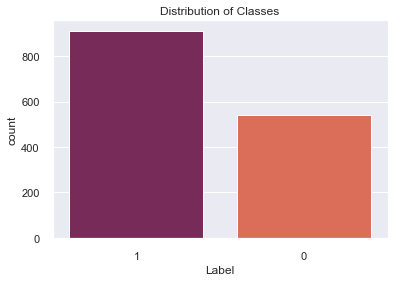

In [31]:
plot_count('Label', Total_df)

In [32]:
Total_df.head()

,Last_freq,Label,word_count,char_count,avg_word,upper,questionmark,Punctuation,dash,Nmistakes,...,Emojii,NumOfCapital,unicode_re,unicode_japanese,N_noun,N_adj,Phone_01,Email_01,www,bitcoin
0,mercedes real independent seeking generous gen...,0,37,260,6.054054,2,0,0,1,22,...,37,2,37,37,0.756757,0.216216,0,0,0,0
1,hyd enjoy taking care man pleasing call met,0,30,197,5.600000,1,0,0,0,17,...,30,2,30,30,0.833333,0.200000,1,0,0,0
2,play white prefer married men like getting eat...,0,47,238,4.085106,3,0,1,1,20,...,47,5,47,47,0.297872,0.191489,1,0,0,0
3,guys come experience something new fun size fe...,0,24,145,5.083333,1,0,0,1,11,...,24,16,24,24,0.875000,0.125000,1,0,0,0
4,come show body best thing could ever play,0,21,106,4.095238,0,0,0,0,11,...,21,0,21,21,0.428571,0.238095,0,0,0,0


# Resample imbalance Class (Not using it)

create a new DataFrame with an up-sampled minority class. Here are the steps:

    1) separate observations from each class into different DataFrames.
    2) resample the minority class with replacement, setting the number of samples to match that of the majority class.
    3) combine the up-sampled minority class DataFrame with the original majority class DataFrame.

from sklearn.utils import resample

# 
Separate majority and minority classes
df_minority = Total_df[Total_df['Label']==0]
df_majority = Total_df[Total_df['Label']==1]

# 
Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=198,     # to match minority class
                                 random_state=123) # reproducible results
 
# 
Combine minority class with downsampled majority class
#df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
#
Display new class counts
#df_downsampled.balance.value_counts()

# Bag og Words N= 1, n=2
Still undecided if I should use lemmatizer or stemmatizer. 
I will try both

In [33]:
# create the lemmatizer
lemmatizer = WordNetLemmatizer()
#apply lemmatizer 
Total_df['lemmatize'] = Total_df['Last_freq'].apply(lemmatizer.lemmatize)

In [34]:
# create the stem
stemmer = PorterStemmer()
#apply stem
Total_df['stem'] = Total_df['lemmatize'].apply(stemmer.stem)

In [35]:
# Create the counter Vectorizer
count_vect_n1 = CountVectorizer(ngram_range=(1, 1), analyzer='word', stop_words = 'english')#, min_df=1)
count_vect_n2 = CountVectorizer(ngram_range=(1, 2), analyzer='word', stop_words = 'english')#, min_df=1)

# TFIDF

In [36]:
# Create the TFIDF vectorizer
vectorizer  = TfidfVectorizer(analyzer='word',stop_words = 'english')

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

# Trasform Words into Vectors

In [37]:
# BoW n=1 for lemmatize and stem 
vector_bow1_ste = fit_transf(count_vect_n1, Total_df['stem'])
# BoW n=2 for lemmatize and stem 

vector_bow2_ste = fit_transf(count_vect_n2, Total_df['stem'])
# TFIDF for lemmatize and stem 

vector_tfidf_ste = fit_transf(vectorizer, Total_df['stem'])

In [38]:
# get feature name
feature_names_n1    = count_vect_n1.get_feature_names()
feature_names_n2    = count_vect_n2.get_feature_names()
feature_names_tfidf = vectorizer.get_feature_names()

In [39]:
# prin top feature for tfidf
top_feat(vectorizer,    feature_names_tfidf,20)

['ztext', 'inland', 'jazzi', 'jazmyne', 'jaz', 'jayla', 'jasmin', 'japankoreataiwan', 'japan', 'james', 'jail', 'jade', 'jada', 'iverson', 'iust', 'itless', 'iteetig', 'jazzy', 'jealous', 'jeans']


# Meta features

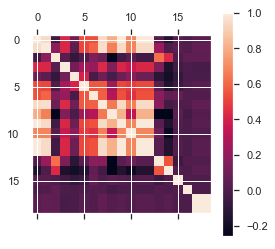

In [40]:

Total_meta = Total_df[['word_count', 'char_count', 'avg_word', 'upper', 'questionmark', 'Punctuation', 'dash', 'Nmistakes', 'stopwords','Emojii', 'NumOfCapital', 'unicode_re', 'unicode_japanese', 'N_noun','N_adj', 'Phone_01', 'Email_01', 'www', 'bitcoin']]

plt.matshow(Total_meta.corr())
plt.colorbar()

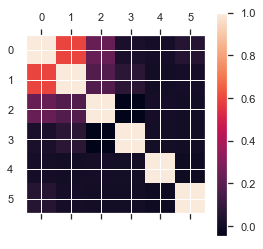

In [41]:
Total_meta2 = Total_meta[['char_count', 'dash', 'N_noun' ,'Phone_01', 'Email_01', 'bitcoin']]
plt.matshow(Total_meta2.corr())
plt.colorbar()

In [42]:
import numpy
from scipy.sparse import csr_matrix
Matrix = csr_matrix(Total_meta2.values)
features_bow1 = scipy.sparse.hstack([vector_bow1_ste, Matrix])
features_bow2 = scipy.sparse.hstack([vector_bow2_ste, Matrix])
features_tfidf = scipy.sparse.hstack([vector_tfidf_ste, Matrix])

# Visualize the features
When you use Bag of Words, each of your sentences gets represented in a high dimensional 
space of length equal to the vocabulary. 
If you want to represent this in 2D you need to reduce the dimension,
for example using PCA with two components:


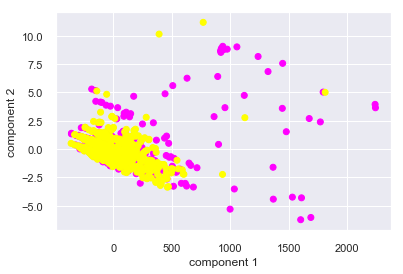

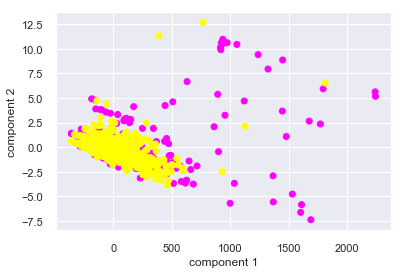

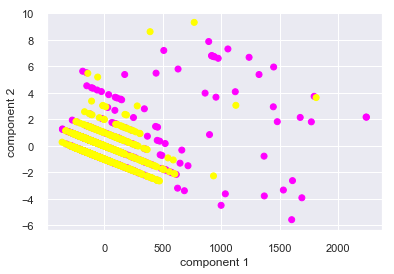

In [75]:
feat_clust_pca(features_bow1,Total_df['Label'])

feat_clust_pca(features_bow2,Total_df['Label'])

feat_clust_pca(features_tfidf,Total_df['Label'])

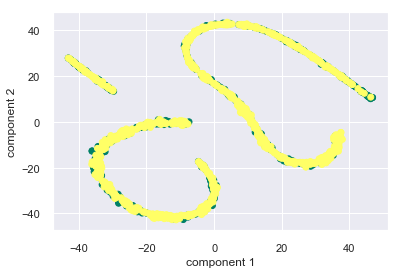

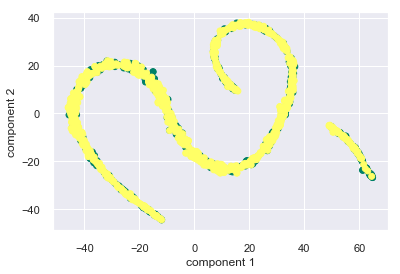

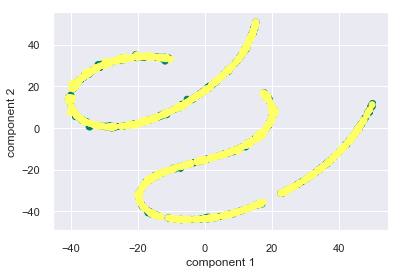

In [76]:
feat_clust_tsne(features_bow1,Total_df['Label'])

feat_clust_tsne(features_bow2,Total_df['Label'])

feat_clust_tsne(features_tfidf,Total_df['Label'])

# Sparcicity for the matrix

In [77]:
sparc(vector_bow1_ste)

sparc(vector_bow2_ste)

sparc(vector_tfidf_ste)

Sparsicity: 0.6157053560848441 %
Sparsicity: 0.23112291690310627 %
Sparsicity: 0.6157053560848441 %


# 2. Prediction
Before doing analysis, we have to decide the metric to compare between different models
We want recall to be the best, aka the number of false negative to be the lowest


In [43]:
accuracy = {}
recall    = {}
confusion_mat = {}
precision = {}
predictions = {}
# BoW 1
accuracy_bow1 = {}
recall_bow1   = {}
confusion_mat_bow1 = {}
precision_bow1 = {}
predictions_bow1 = {}
# BoW 2
accuracy_bow2 = {}
recall_bow2   = {}
confusion_mat_bow2 = {}
precision_bow2 = {}
predictions_bow2   = {}
# Tfidf
accuracy_tfidf = {}
recall_tfidf   = {}
confusion_mat_tfidf = {}
precision_tfidf = {}
predictions_tfidf   = {}

# Split the dataset

In [44]:
labels = Total_df["Label"]
labels = labels.astype(int)

## Initial text features with meta feature:

In [45]:
Xtrain_bow1_ste,  Xtest_bow1_ste,  ytrain_bow1_ste,  ytest_bow1_ste  = train_t_s(features_bow1, labels)

Xtrain_bow2_ste,  Xtest_bow2_ste,  ytrain_bow2_ste,  ytest_bow2_ste  = train_t_s(features_bow2, labels)

Xtrain_tfidf_ste, Xtest_tfidf_ste, ytrain_tfidf_ste, ytest_tfidf_ste = train_t_s(features_tfidf, labels)

(1164, 3718) (1164,) (291, 3718)
(1164, 20172) (1164,) (291, 20172)
(1164, 3718) (1164,) (291, 3718)


## Reduced number of features (not used, regularization instead)
Reduce Feature for reduce high variance:
Chi squared for feauture reduction
A chi-squared test finds the words that discriminate the most
One downside of this is that we are using knowledge from the dataset to select features, and thus introducing some overfitting. We could get around the overfitting in the "real world" by using a subset of the data for feature selection, and using a different subset for training the algorithm. We'll make things a bit simpler for now and skip that step.

# feature reduction for the best feature 
Xtrain_red_bow1, Xtest_red_bow1, feature_names_best_bow1 = chi2_kbest(Xtrain_bow1_ste, ytrain_bow1_ste, Xtest_bow1_ste, feature_names_n1, 2000)
Xtrain_red_bow2, Xtest_red_bow2, feature_names_best_bow2 = chi2_kbest(Xtrain_bow2_ste, ytrain_bow2_ste, Xtest_bow2_ste, feature_names_n2, 8000)
Xtrain_red_tfidf,  Xtest_red_tfidf, feature_names_best_tfidf = chi2_kbest(Xtrain_tfidf_ste, ytrain_tfidf_ste, Xtest_tfidf_ste,feature_names_tfidf  , 2000)

chi2_kbest_plot(Xtrain_red_bow1, ytrain_bow1_ste, Xtest_red_bow1, feature_names_best_bow1)


chi2_kbest_plot(Xtrain_red_bow2, ytrain_bow2_ste, Xtest_red_bow2, feature_names_best_bow2)

chi2_kbest_plot(Xtrain_red_tfidf, ytrain_tfidf_ste , Xtest_red_tfidf, feature_names_best_tfidf)

# Initialize the different models

In [82]:
A = MultinomialNB(alpha=1.0)#,fit_prior=False
B = DecisionTreeClassifier(random_state=42, class_weight={1: 2})
C = AdaBoostClassifier(n_estimators=100) 
D = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42,class_weight={1: 2})
E = LogisticRegression(class_weight ={1: 2})#solver = 'lbfgs',
F = SVC(gamma='auto', class_weight={1: 2})#kernel='linear',

# Optimize model for TFIDF features
RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.

## Multi-Naive Bayes

In [83]:
#'alpha', 'class_prior', 'fit_prior', 'norm'
alpha = np.linspace(1.0e-10, 10, 20)
fit_prior = [True,False]
param_grid = dict(alpha=alpha, fit_prior=fit_prior)

random = RandomizedSearchCV(estimator=A, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_bow1_ste, ytrain_bow1_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.772207 using {'fit_prior': False, 'alpha': 3.6842105263789473}


In [84]:
#'alpha', 'class_prior', 'fit_prior', 'norm'
alpha = np.linspace(1.0e-10, 10, 20)
fit_prior = [True,False]
param_grid = dict(alpha=alpha, fit_prior=fit_prior)

random = RandomizedSearchCV(estimator=A, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_bow2_ste, ytrain_bow2_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.770722 using {'fit_prior': False, 'alpha': 1.578947368505263}


In [85]:
#'alpha', 'class_prior', 'fit_prior', 'norm'
alpha = np.linspace(1.0e-10, 10, 20)
fit_prior = [True,False]

param_grid = dict(alpha=alpha, fit_prior=fit_prior)

random = RandomizedSearchCV(estimator=A, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_tfidf_ste, ytrain_tfidf_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.768905 using {'fit_prior': True, 'alpha': 9.473684210531578}


## Decision tree

1) The first parameter to tune is max_depth : how deep the tree can go

2) min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node. 

3) min_samples_leaf is The minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs, the base of the tree.

4) max_features represents the number of features to consider when looking for the best split.

In [86]:
F.get_params().keys()


dict_keys(['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [87]:
max_depths = np.linspace(2, 32, 32, dtype=int)
min_samples_splits = np.linspace(2, 10, 8, dtype=int)
max_features = list(range(1, Xtrain_bow1_ste.shape[1] - 1))

param_grid = dict(max_depth=max_depths,min_samples_split=min_samples_splits,max_features=max_features)

random = RandomizedSearchCV(estimator=B, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_bow1_ste, ytrain_tfidf_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.769232 using {'min_samples_split': 8, 'max_features': 1894, 'max_depth': 2}


In [88]:
max_depths = np.linspace(2, 32, 32, dtype=int)
min_samples_splits = np.linspace(2, 10, 8, dtype=int)
max_features = list(range(1, Xtrain_bow2_ste.shape[1] - 1))

param_grid = dict(max_depth=max_depths,min_samples_split=min_samples_splits,max_features=max_features)

random = RandomizedSearchCV(estimator=B, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_bow2_ste, ytrain_tfidf_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.772659 using {'min_samples_split': 8, 'max_features': 12838, 'max_depth': 6}


In [89]:
max_depths = np.linspace(2, 32, 32, dtype=int)
min_samples_splits = np.linspace(2, 10, 8, dtype=int)
max_features = list(range(1, Xtrain_tfidf_ste.shape[1] - 1))

param_grid = dict(max_depth=max_depths,min_samples_split=min_samples_splits,max_features=max_features)

random = RandomizedSearchCV(estimator=B, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_tfidf_ste, ytrain_tfidf_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.769654 using {'min_samples_split': 3, 'max_features': 1509, 'max_depth': 5}


## Random Forest
If int, then consider max_features features at each split.
If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
If “auto”, then max_features=sqrt(n_features).
If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
If “log2”, then max_features=log2(n_features).
If None, then max_features=n_features.

In [66]:
n_estimators = np.linspace(10, 200, 10,dtype=int) # Number of trees in random forest
min_samples_splits = np.linspace(2, 10, 8, dtype=int)
max_features = [1000,'auto','log2',None]
max_depths = np.linspace(2, 32, 32, dtype=int)
param_grid = dict(n_estimators=n_estimators,max_depth=max_depths,min_samples_split=min_samples_splits,max_features=max_features)

random = RandomizedSearchCV(estimator=D, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_bow1_ste, ytrain_bow1_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.780596 using {'n_estimators': 157, 'min_samples_split': 10, 'max_features': 1000, 'max_depth': 18}


In [91]:
# Number of trees in random forest
n_estimators = np.linspace(10, 200, 10,dtype=int)
min_samples_splits = np.linspace(2, 10, 8, dtype=int)
max_features = list(range(1, Xtrain_bow2_ste.shape[1] - 1))

param_grid = dict(max_depth=max_depths,min_samples_split=min_samples_splits,max_features=max_features)

random = RandomizedSearchCV(estimator=D, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_bow2_ste, ytrain_bow2_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.774998 using {'min_samples_split': 4, 'max_features': 6260, 'max_depth': 7}


In [92]:
# Number of trees in random forest
n_estimators = np.linspace(10, 200, 10,dtype=int)
min_samples_splits = np.linspace(2, 10, 8, dtype=int)
max_features = list(range(1, Xtrain_tfidf_ste.shape[1] - 1))

param_grid = dict(max_depth=max_depths,min_samples_split=min_samples_splits,max_features=max_features)

random = RandomizedSearchCV(estimator=D, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_tfidf_ste, ytrain_tfidf_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.773761 using {'min_samples_split': 3, 'max_features': 3000, 'max_depth': 7}


## LogisticRegression

In [93]:
E.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [96]:
max_iter = np.linspace(200, 2000, 50,dtype=int)
C  = [1.0,1.5,2.0,2.5,3.0]
penalty = ['l1']#Built-in feature selection 
solver =  [ "saga","liblinear"]
param_grid = dict(C=C,  max_iter=max_iter, penalty=penalty, solver=solver)

random = RandomizedSearchCV(estimator=E, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_bow1_ste, ytrain_bow1_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.768905 using {'solver': 'saga', 'penalty': 'l1', 'max_iter': 1963, 'C': 2.0}


/Users/cristiana/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [97]:
max_iter = np.linspace(200, 2000, 50,dtype=int)
C  = [1.0,1.5,2.0,2.5,3.0]
penalty = ['l1']
solver =  ["saga", "liblinear"]
param_grid = dict(C=C, solver=solver, max_iter=max_iter, penalty=penalty)

random = RandomizedSearchCV(estimator=E, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_bow2_ste, ytrain_bow2_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.768905 using {'solver': 'saga', 'penalty': 'l1', 'max_iter': 420, 'C': 2.5}


/Users/cristiana/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [98]:
max_iter = np.linspace(200, 2000, 50,dtype=int)
C  = [1.0,1.5,2.0,2.5,3.0]
penalty = ['l1']
solver =  [ "saga", "liblinear"]
param_grid = dict(C=C, solver=solver, max_iter=max_iter, penalty=penalty)

random = RandomizedSearchCV(estimator=E, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_tfidf_ste, ytrain_tfidf_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.777585 using {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 1081, 'C': 1.5}


## SVM Classify

In [99]:
kernel= ['linear', 'poly', 'rbf', 'sigmoid']
gamma =  np.arange(0.1, 1, 0.2)
C = np.arange(2, 10, 2)
param_grid = dict(C=C, gamma = gamma, kernel = kernel)
random = RandomizedSearchCV(estimator=F, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_bow1_ste, ytrain_bow1_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.768905 using {'kernel': 'rbf', 'gamma': 0.9000000000000001, 'C': 8}


In [100]:
kernel= ['linear', 'poly', 'rbf', 'sigmoid']
gamma =  np.arange(0.1, 1, 0.2)
C = np.arange(2, 10, 2)
param_grid = dict(C=C, gamma = gamma, kernel = kernel)
random = RandomizedSearchCV(estimator=F, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_bow2_ste, ytrain_bow2_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.769066 using {'kernel': 'rbf', 'gamma': 0.1, 'C': 2}


In [102]:
kernel= ['linear', 'poly', 'rbf', 'sigmoid']
gamma =  np.arange(0.1, 1, 0.2)
C = np.arange(2, 10, 2)
param_grid = dict(C=C, gamma = gamma, kernel = kernel)
random = RandomizedSearchCV(estimator=F, scoring='f1',param_distributions=param_grid, cv = 3, n_jobs=-1)
random_result = random.fit(Xtrain_tfidf_ste, ytrain_tfidf_ste)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

KeyboardInterrupt: 

# Best models for BoW1

In [74]:
A = MultinomialNB(alpha=4,fit_prior=False)
B = DecisionTreeClassifier(random_state=42, class_weight={1: 2}, max_features=1000)
C = AdaBoostClassifier(n_estimators=100) 
D = RandomForestClassifier(n_estimators=10, max_features='auto', min_samples_split=2, random_state=42,class_weight={1: 2})
E = LogisticRegression(max_iter=2000,solver = 'saga', penalty='l1', class_weight ={1: 2}, C = 3.0)
F = SVC(kernel='rbf',gamma=0.1, class_weight={1: 2}, C = 4)

# Best models for TFIDF

A = MultinomialNB(alpha=4,fit_prior=False)
B = DecisionTreeClassifier(random_state=42, max_features=1000, class_weight={1: 2}, max_depth= 17)
C = AdaBoostClassifier(n_estimators=100) 
D = RandomForestClassifier(n_estimators=100, max_features=1000, min_samples_split=2, random_state=42,class_weight={1: 2})
E = LogisticRegression(max_iter=2000,solver = 'liblinear', penalty='l1', class_weight ={1: 2}, C = 2.0)
F = SVC(kernel='linear',gamma=0.3, class_weight={1: 2}, C = 3)

# Fit, predict and get scores

In [75]:
# Creates a list containing 5 lists, each of 8 items, all set to 0
w, h = 4, 3;
Matrix = [[0 for x in range(w)] for y in range(h)] 

In [76]:
Matrix[0][:] = [Xtrain_bow1_ste,  Xtest_bow1_ste,  ytrain_bow1_ste,  ytest_bow1_ste]
Matrix[1][:] = [Xtrain_bow2_ste,  Xtest_bow2_ste,  ytrain_bow2_ste,  ytest_bow2_ste]
Matrix[2][:] = [Xtrain_tfidf_ste, Xtest_tfidf_ste, ytrain_tfidf_ste, ytest_tfidf_ste ]

In [77]:
# matrix of scores filled with: 
# [train* model] [pre, acc, rec, cm, f1, tpr,fpr]
score_pre = np.zeros((6, 6) , dtype=object)
score_acc = np.zeros((6, 6) , dtype=object)
score_rec = np.zeros((6, 6) , dtype=object)
score_cm  = np.zeros((6, 6) , dtype=object)
score_f1  = np.zeros((6, 6) , dtype=object)
score_fpr = np.zeros((6, 6) , dtype=object)
score_tpr = np.zeros((6, 6) , dtype=object)

In [78]:
# loop to call function for each model
clf  = [A,B,C,D,E,F]
for y in range(0,h):
    for a in range(len(clf)):
        train_classifier(clf[a], Matrix[y][0], Matrix[y][2])
        y_pred = predict_labels(clf[a],Matrix[y][1])
        print('for model = '+str(a))
        score_pre[y][a], score_acc[y][a], score_rec[y][a], score_cm[y][a], score_f1[y][a], score_fpr[y][a], score_tpr[y][a] = metric(clf[a], Matrix[y][1], Matrix[y][3]) # 2 = y        

for model = 0
Accuracy =  68.38487972508591 %, Recall =  99.45945945945947 %, Precision =  66.9090909090909 %, f1 = 80.0
for model = 1
Accuracy =  66.66666666666666 %, Recall =  79.45945945945945 %, Precision =  71.35922330097088 %, f1 = 75.1918158567775
for model = 2
Accuracy =  67.69759450171821 %, Recall =  80.54054054054053 %, Precision =  71.98067632850241 %, f1 = 76.02040816326532
for model = 3
Accuracy =  67.69759450171821 %, Recall =  77.83783783783784 %, Precision =  73.09644670050761 %, f1 = 75.39267015706807


/Users/cristiana/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


for model = 4
Accuracy =  63.57388316151202 %, Recall =  100.0 %, Precision =  63.57388316151202 %, f1 = 77.73109243697479
for model = 5
Accuracy =  63.230240549828174 %, Recall =  97.2972972972973 %, Precision =  63.829787234042556 %, f1 = 77.08779443254818
for model = 0
Accuracy =  64.94845360824742 %, Recall =  100.0 %, Precision =  64.45993031358886 %, f1 = 78.38983050847457
for model = 1
Accuracy =  68.72852233676976 %, Recall =  81.08108108108108 %, Precision =  72.81553398058253 %, f1 = 76.72634271099746
for model = 2
Accuracy =  65.97938144329896 %, Recall =  80.54054054054053 %, Precision =  70.28301886792453 %, f1 = 75.06297229219143
for model = 3
Accuracy =  68.72852233676976 %, Recall =  87.02702702702703 %, Precision =  70.6140350877193 %, f1 = 77.96610169491525


/Users/cristiana/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


for model = 4
Accuracy =  63.57388316151202 %, Recall =  100.0 %, Precision =  63.57388316151202 %, f1 = 77.73109243697479
for model = 5
Accuracy =  62.88659793814433 %, Recall =  98.37837837837839 %, Precision =  63.41463414634146 %, f1 = 77.11864406779661
for model = 0
Accuracy =  63.57388316151202 %, Recall =  100.0 %, Precision =  63.57388316151202 %, f1 = 77.73109243697479
for model = 1
Accuracy =  66.32302405498281 %, Recall =  77.83783783783784 %, Precision =  71.64179104477611 %, f1 = 74.61139896373057
for model = 2
Accuracy =  66.32302405498281 %, Recall =  77.29729729729729 %, Precision =  71.85929648241206 %, f1 = 74.47916666666666
for model = 3
Accuracy =  62.54295532646048 %, Recall =  76.75675675675676 %, Precision =  68.26923076923077 %, f1 = 72.26463104325701


/Users/cristiana/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


for model = 4
Accuracy =  63.57388316151202 %, Recall =  100.0 %, Precision =  63.57388316151202 %, f1 = 77.73109243697479
for model = 5
Accuracy =  60.48109965635739 %, Recall =  81.62162162162161 %, Precision =  65.08620689655173 %, f1 = 72.42206235011992


# Check different scores results

In [79]:
objects = ('Multi-NB', 'DT', 'AdaBoost', 'RF','LR','SVC')

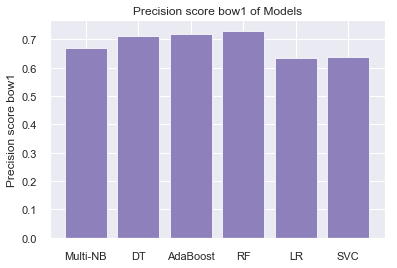

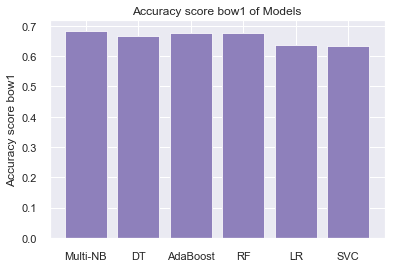

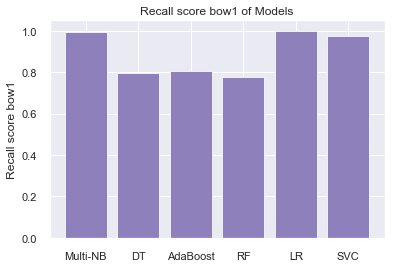

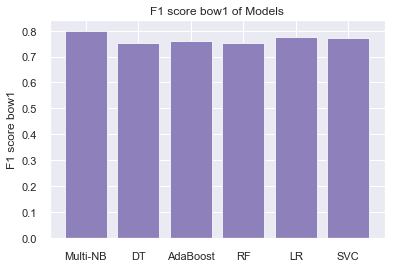

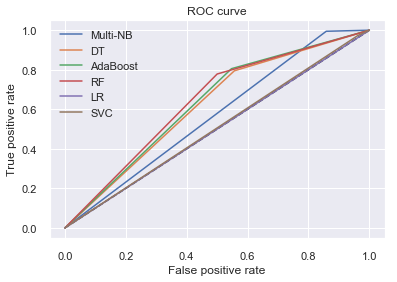

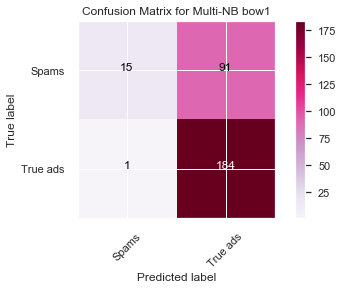

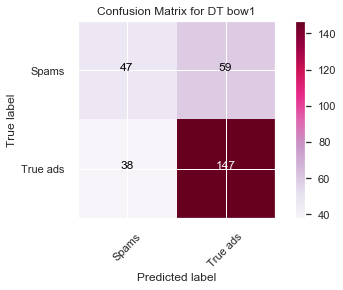

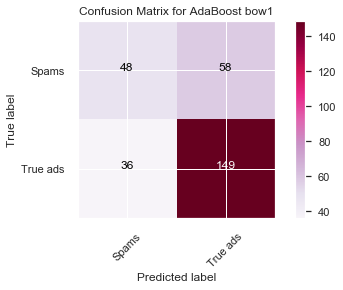

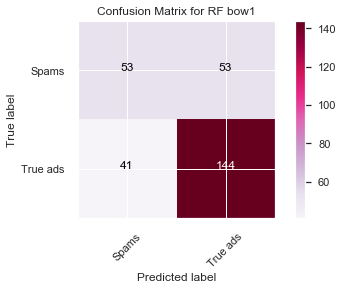

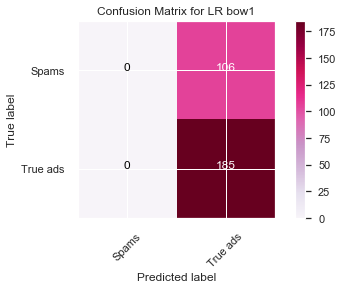

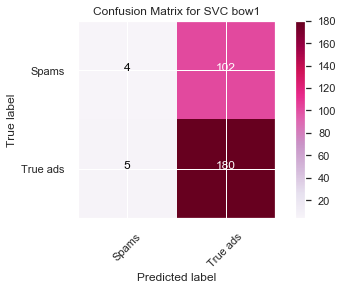

In [80]:
# ploating data for the scores/ model
# bow1_ste
plot_res(objects,score_pre[0][:] ,"Precision score bow1")
plot_res(objects,score_acc[0][:] ,"Accuracy score bow1")
plot_res(objects,score_rec[0][:] ,"Recall score bow1")
plot_res(objects,score_f1[0][:] , "F1 score bow1")
plot_auc_curve(objects, score_fpr[0][:], score_tpr[0][:], "ROC curve")
for a in range(len(clf)):
    plot_confusion_matrix(score_cm[0][a], classes=['Spams','True ads'],normalize=False, title='Confusion Matrix for '+str(objects[a])+' bow1',cmap=plt.cm.PuRd)
    plt.colorbar()
    plt.show()

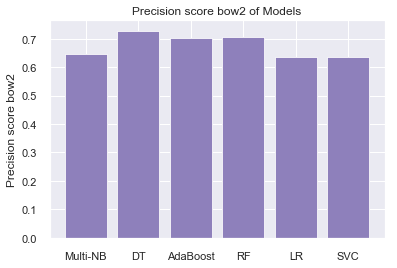

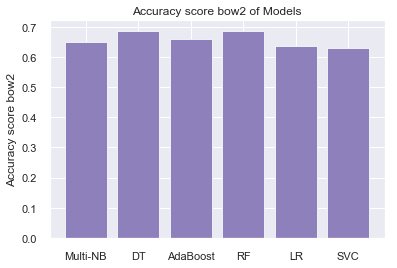

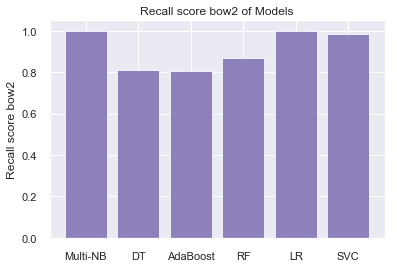

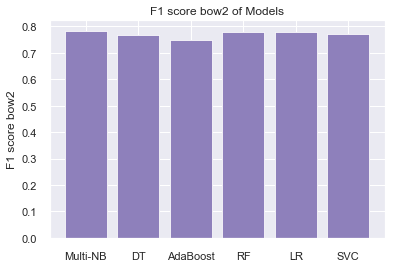

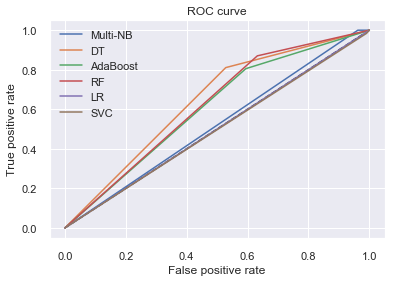

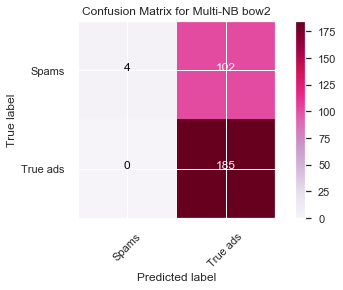

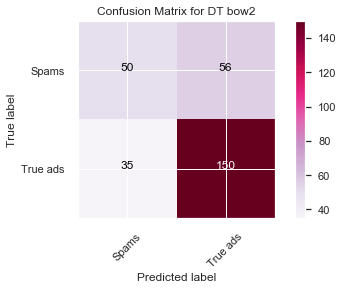

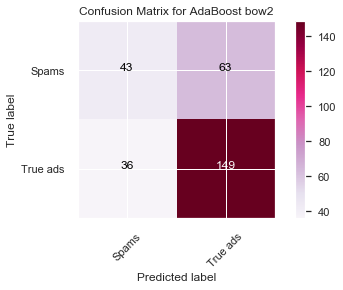

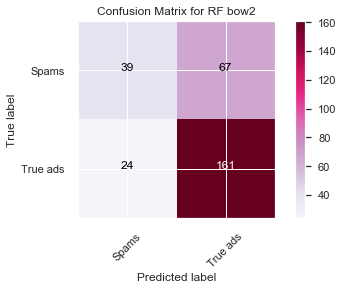

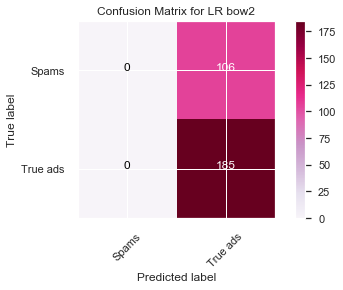

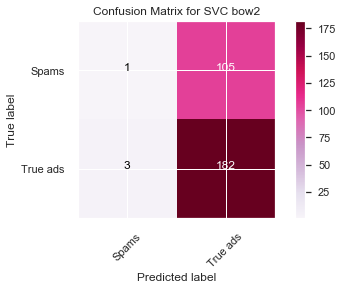

In [81]:
#b2_ste
plot_res(objects,score_pre[1][:] ,"Precision score bow2")
plot_res(objects,score_acc[1][:] ,"Accuracy score bow2")
plot_res(objects,score_rec[1][:] ,"Recall score bow2")
plot_res(objects,score_f1[1][:] , "F1 score bow2")
plot_auc_curve(objects, score_fpr[1][:], score_tpr[1][:], "ROC curve")
for a in range(len(clf)):
    plot_confusion_matrix(score_cm[1][a], classes=['Spams','True ads'],normalize=False, title='Confusion Matrix for '+str(objects[a])+' bow2',cmap=plt.cm.PuRd)
    plt.colorbar()
    plt.show()

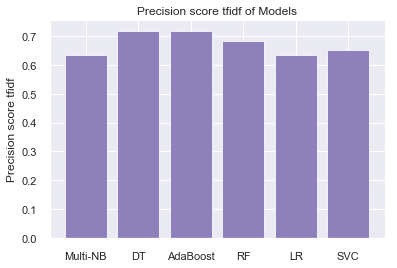

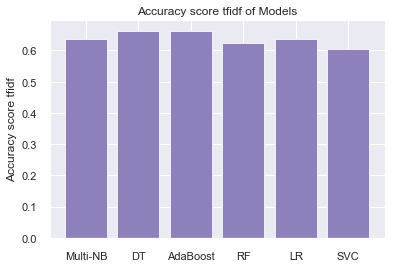

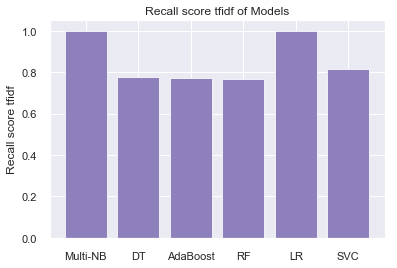

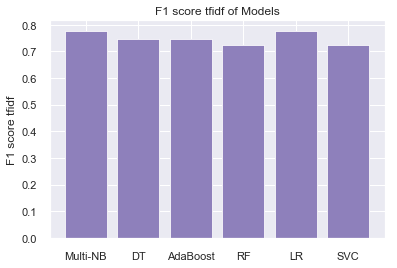

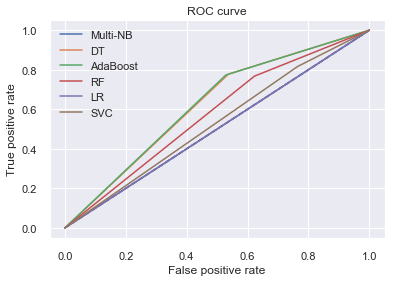

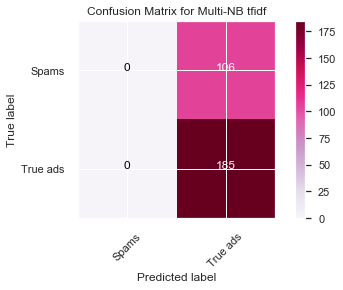

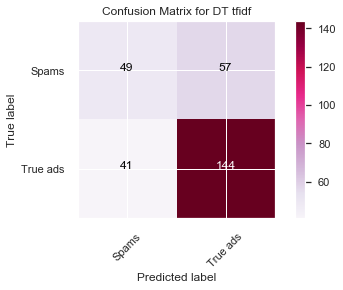

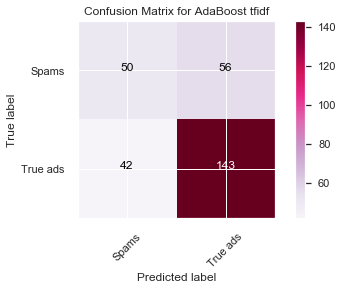

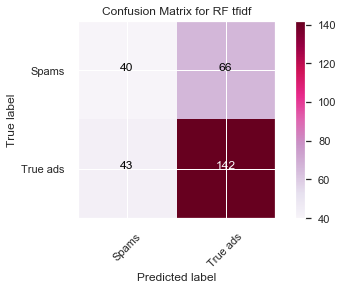

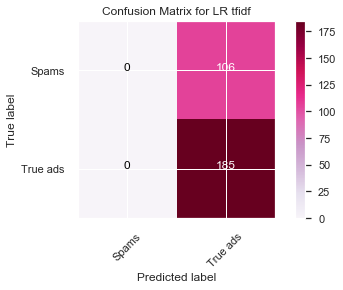

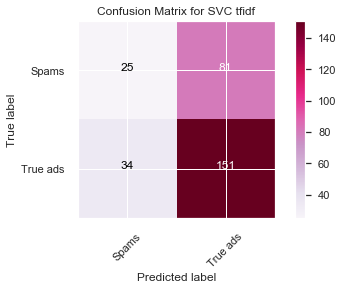

In [82]:
#tfidf ste
plot_res(objects,score_pre[2][:] ,"Precision score tfidf")
plot_res(objects,score_acc[2][:] ,"Accuracy score tfidf")
plot_res(objects,score_rec[2][:] ,"Recall score tfidf")
plot_res(objects,score_f1[2][:] , "F1 score tfidf")
plot_auc_curve(objects, score_fpr[2][:], score_tpr[2][:], "ROC curve")
for a in range(len(clf)):
    plot_confusion_matrix(score_cm[2][a], classes=['Spams','True ads'],normalize=False, title='Confusion Matrix for '+str(objects[a])+' tfidf',cmap=plt.cm.PuRd)
    plt.colorbar()
    plt.show()

# Learning curve and errors for best ones

Train score mean  [1. 1. 1. 1. 1.]  +-  [0. 0. 0. 0. 0.]
Test score mean   [0.92068364 0.90180319 0.89220303 0.89064393 0.88444497]  +-  [0.06557554 0.03977587 0.03356938 0.02925164 0.02682855]
cv:  ShuffleSplit(n_splits=100, random_state=42, test_size=0.2, train_size=None)
train size: [ 93 302 512 721 931]


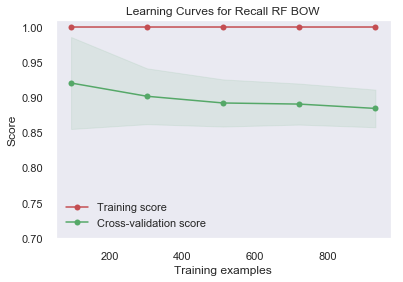

In [61]:
title = "Learning Curves for Recall RF BOW"
test_error =[]
train_error = []
D = RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=42,class_weight={1: 2})

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plt, train_error, test_error = plot_learning_curve(D, title, Xtrain_bow1_ste, ytrain_bow1_ste, ylim=(0.7, 1.01), cv=cv, n_jobs=5)
plt.show()


In [62]:
train_error, test_error

([array([0., 0., 0., 0., 0.])],
 [array([0.06557554, 0.03977587, 0.03356938, 0.02925164, 0.02682855])])

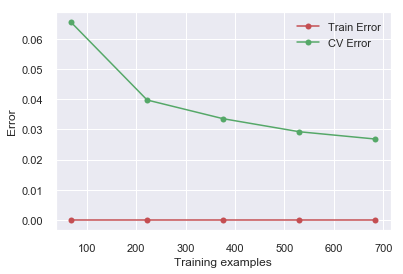

In [63]:
x = [68,222,376,530,684]
y = [0., 0., 0., 0., 0.]
z = [0.06557554, 0.03977587, 0.03356938, 0.02925164, 0.02682855]
plt.plot(x, y, 'o-', color="r",label='Train Error')
plt.plot(x, z, 'o-', color="g",label='CV Error')
plt.xlabel("Training examples")
plt.ylabel("Error")
plt.legend(loc="best")
plt.show()

Train score mean  [0.99463918 0.99232589 0.99157052 0.99260011 0.99171412]  +-  [0.01011465 0.0072543  0.00507888 0.00394293 0.00337126]
Test score mean   [0.82778191 0.80769372 0.80522322 0.79937782 0.8029759 ]  +-  [0.10134401 0.05478721 0.04862265 0.04026589 0.03584045]
cv:  ShuffleSplit(n_splits=100, random_state=42, test_size=0.2, train_size=None)
train size: [ 93 302 512 721 931]


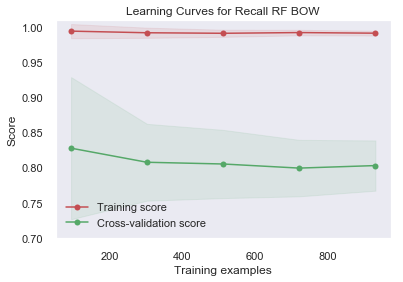

In [70]:
title = "Learning Curves for Recall RF BOW"
test_error =[]
train_error = []
D = RandomForestClassifier(n_estimators=10, max_features='auto', min_samples_split=2, random_state=42,class_weight={1: 2})

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plt, train_error, test_error = plot_learning_curve(D, title, Xtrain_tfidf_ste, ytrain_tfidf_ste, ylim=(0.7, 1.01), cv=cv, n_jobs=5)
plt.show()


In [71]:
train_error, test_error

([array([0.01011465, 0.0072543 , 0.00507888, 0.00394293, 0.00337126])],
 [array([0.10134401, 0.05478721, 0.04862265, 0.04026589, 0.03584045])])

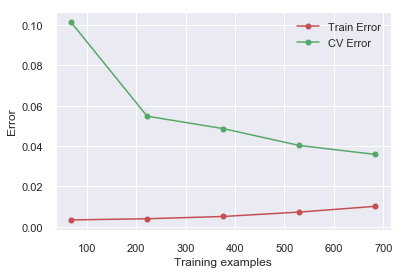

In [73]:
x = [68,222,376,530,684]
y = [0.00337126, 0.00394293,0.00507888,0.0072543 ,0.0101146 ]
z = [0.10134401, 0.05478721, 0.04862265, 0.04026589, 0.03584045]
plt.plot(x, y, 'o-', color="r",label='Train Error')
plt.plot(x, z, 'o-', color="g",label='CV Error')
plt.xlabel("Training examples")
plt.ylabel("Error")
plt.legend(loc="best")
plt.show()

# K fold: estimator vs baseline

In [83]:
from sklearn.dummy import DummyClassifier
estimator_dummy = DummyClassifier()
estimator =RandomForestClassifier(n_estimators=10, max_features='auto', min_samples_split=2, random_state=42,class_weight={1: 2})

In [84]:
k_fold(10, estimator, Xtrain_bow1_ste, ytrain_tfidf_ste, 'recall')
k_fold(10, estimator_dummy, Xtrain_bow1_ste, ytrain_tfidf_ste, 'recall')

Average scoring =  0.7820752724634652  +/-  0.03128639945559221
Average scoring =  0.6259034641524515  +/-  0.040785954867635255


In [85]:
k_fold(10, estimator, Xtrain_bow1_ste, ytrain_tfidf_ste, 'accuracy')
k_fold(10, estimator_dummy, Xtrain_bow1_ste, ytrain_tfidf_ste, 'accuracy')

Average scoring =  0.6606027114647804  +/-  0.023154211745662224
Average scoring =  0.5386752136752135  +/-  0.034474184253915734


In [86]:
k_fold(10, estimator, Xtrain_bow1_ste, ytrain_tfidf_ste, 'precision')
k_fold(10, estimator_dummy, Xtrain_bow1_ste, ytrain_tfidf_ste, 'precision')

Average scoring =  0.7060844098575624  +/-  0.0384513268146684
Average scoring =  0.6235621507163438  +/-  0.0738817576038408


# Most important feature

In [107]:
#Random forest
feature_importances = pd.DataFrame(D.feature_importances_)
coefs_with_fns = sorted(zip(D.feature_importances_, feature_names_n1), reverse=True)
importances = D.feature_importances_
indices = np.argsort(D.feature_importances_)[::-1]
#for (coef_1, fn_1) in coefs_with_fns:
 #   print ("\t%.4f\t%-15s\t" % (coef_1, fn_1 ) )




In [158]:
coefs_with_fns[:10]

[(0.01088428725271611, 'hit'),
 (0.006536894218365346, 'enjoy'),
 (0.006169442466118697, 'host'),
 (0.005888184448912854, 'fun'),
 (0.0058776523870902285, 'sex'),
 (0.005858770878651499, 'pay'),
 (0.005565287702144815, 'shaved'),
 (0.005530379089870562, 'contact'),
 (0.005380655659271157, 'hey'),
 (0.005349466440710845, 'wet')]

In [153]:
coefs, name = zip(*coefs_with_fns[:5])

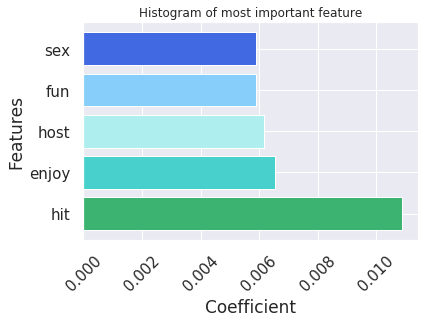

In [157]:
fig, ax = plt.subplots()


ax.barh(name[:5],coefs[:5],color = ['mediumseagreen','mediumturquoise','paleturquoise','lightskyblue','royalblue'])


patches[1].set_facecolor('darkgreen')
patches[2].set_facecolor('mediumseagreen')
patches[3].set_facecolor('mediumturquoise')
patches[4].set_facecolor('paleturquoise')
patches[5].set_facecolor('lightskyblue')


ind=np.array(bins[:-1])
width = np.array([bins[i+1]-bins[i] for i in range(len(bins)-1)])

plt.title('Histogram of most important feature')

plt.ylabel('Features',fontsize=17)
plt.xlabel('Coefficient',fontsize=17)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
#Logistic regression
estimator = LogisticRegression(max_iter = 2000, solver = 'liblinear', penalty='l1', class_weight ={1: 2}, C = 2.0)
logmodel = estimator.fit(Xtrain_bow1_ste, ytrain_tfidf_ste)



In [ ]:
coef_dict = dict(zip(feature_names_n1, logmodel.coef_[0]))

In [ ]:
sorted_by_value_top = sorted(coef_dict.items(), key=lambda kv: kv[1],reverse=True)
sorted_by_value_bot = sorted(coef_dict.items(), key=lambda kv: kv[1],reverse=False)

In [ ]:
sorted_by_value_top[:15]

In [ ]:
sorted_by_value_bot[:15]

# Predict Probability insted of yes/no

In [89]:
prob = D.predict_proba(Xtrain_bow1_ste)

We can rank observations by probability of diabetes


Prioritize contacting those with a higher probability


In [90]:
# store the predicted probabilities for class 1 
y_pred_prob_ads = D.predict_proba(Xtest_bow1_ste)[:, 1]


In [91]:
ytest_bow1_ste.index
ytest_bow1_new = pd.Series(index=ytest_bow1_ste.index)

/Users/cristiana/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


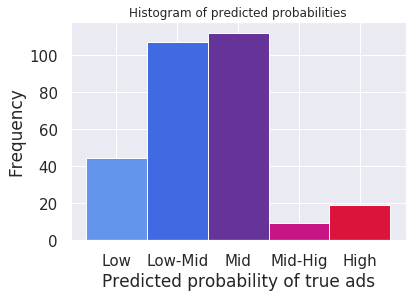

In [92]:
from matplotlib import rcParams
rcParams['font.sans-serif'] = 'Computer Modern Sans Serif'
fig, ax = plt.subplots()


N, bins, patches = ax.hist(y_pred_prob_ads, bins=5, edgecolor='white', linewidth=1)

for i in range(0,1):
    patches[i].set_facecolor('cornflowerblue')
for i in range(1,2):
    patches[i].set_facecolor('royalblue')
for i in range(2,3):
    patches[i].set_facecolor('rebeccapurple')
for i in range(3,4):
    patches[i].set_facecolor('mediumvioletred')
for i in range(4,5):
    patches[i].set_facecolor('crimson')


ind=np.array(bins[:-1])
width = np.array([bins[i+1]-bins[i] for i in range(len(bins)-1)])

plt.title('Histogram of predicted probabilities')
ax.set_xticks(ind + width/2)
ax.set_xticklabels(('Low', 'Low-Mid', 'Mid', 'Mid-Hig', 'High'))
plt.xlabel('Predicted probability of true ads',fontsize=17)
plt.ylabel('Frequency',fontsize=17)
plt.xticks( fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
count = 0
ytest_bow1_new_list =[]
for i in y_pred_prob_ads:
    if i >= 0 and i <=0.2:
        class_name = 0
        
    elif (i > 0.2 and i <=0.4):
        class_name = 1
       
    elif (i > 0.4 and i <=0.6):
        class_name = 2
       
    elif (i > 0.6 and i <=0.8):
        class_name = 3
       
    elif (i > 0.8 and i <=1.0):
        class_name = 4
      
    ytest_bow1_new_list.append(class_name)
    y_pred_prob_ads[count] = class_name
    count+=1
print(count)
        #y_test, y_pred_class

In [ ]:
ytest_bow1_new = pd.Series(ytest_bow1_new_list, index=ytest_bow1_ste.index)


In [ ]:
#cm   = confusion_matrix(ytest_bow1_new, y_pred_prob_ads)
print(ytest_bow1_new.shape, y_pred_prob_ads.shape)

In [ ]:
cm   = confusion_matrix(ytest_bow1_new, y_pred_prob_ads)
cm

In [ ]:
plot_confusion_matrix(cm, classes=['Low','Low-Mid','Mid','Mid-High','High'],normalize=False, title='Confusion Matrix for classes',cmap=plt.cm.PuRd)#bwr)#PiYG)
plt.xticks( fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar()
plt.show()

# Check for systematic errors
Check manually which might be the errors

In [ ]:
def Mis_text(ytest, pred):
    missclassified = np.nonzero(pred!=ytest)[0]
    ind_miss = ytest.index[missclassified]
    newpd = pd.DataFrame(Total_df.iloc[ind_miss,:])
    return (newpd)

In [ ]:
train_classifier(estimator, Xtrain_bow1_ste, ytrain_bow1_ste)
pred = estimator.predict(Xtest_bow1_ste)
Miss_text_bow1 = Mis_text(ytest_bow1_ste, pred)
Miss_text_bow1.to_csv('LR_prediction_wrong_bow1_feb18.csv')
#Miss_text_bow2.to_csv('SVM_prediction_wrong_bow2_feb2.csv')
#Miss_text_tfidf.to_csv('SVM_prediction_wrong_TFIDF_feb2.csv')


In [ ]:
Miss_text_bow1